# Gradient Boosting Machines - GBM
- Adaboost'un sınıflandırma ve regresyon problemlerine kolayca uyarlanabilen genelleştirilmiş versiyonudur.
- Artıklar üzerine tek bir tahminsel model formunda olan modeller serisi kurulur.
- GBM,tek bir tahminsel model formunda olan modeller serisi oluşturur.
- Seri içerisindeki bir model serideki bir önceki modelin tahmin artıklarının/hatalarının(residuals) üzerine kurularak(fit) oluşturulur.
- GBM, diferansiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient Descent Algoritmasını kullanmaktadır.
- GBM, bir çok temel öğrenici tipi (baselearner type) kullanabilir.(Trees,Liner terms, Splines...)
- Cost fonksiyonları ve link fonksiyonları modifiye edilebilir.
- GBM, Boosting Algoritması + Gradient Descent olarak görülmektedir.

**Gerekli Kütüphaneler** 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
# Uyarı Mesajları ile Karşılaşmamak için bu kütüphaneyi kullanıyoruz.
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)

# Veri Seti Hikayesi ve Problemi: Şeker Hastalığı Tahmini

In [3]:
df = pd.read_csv("./diabetes.csv")
# bu csv dosyasının içerisinde eksik gözlemleri(NA) çıkardık.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Gradient Boosting Machines ve Tahmin İşlemleri

In [4]:
y= df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 42)

**Model**

In [5]:
gbm_model = GradientBoostingClassifier().fit(X_train,y_train)

In [6]:
?gbm_model

Type:        GradientBoostingClassifier
String form: GradientBoostingClassifier()
Length:      100
File:        c:\users\halil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py
Docstring:  
Gradient Boosting for classification.

GB builds an additive model in a
forward stage-wise fashion; it allows for the optimization of
arbitrary differentiable loss functions. In each stage ``n_classes_``
regression trees are fit on the negative gradient of the
binomial or multinomial deviance loss function. Binary classification
is a special case where only a single regression tree is induced.

Read more in the :ref:`User Guide <gradient_boosting>`.

Parameters
----------
loss : {'deviance', 'exponential'}, default='deviance'
    loss function to be optimized. 'deviance' refers to
    deviance (= logistic regression) for classification
    with probabilistic outputs. For loss 'exponential' gradient
    boosting recovers the AdaBoost algorithm.

learning_rate : float, default=0.1
    learning rate 

**Tahmin**

In [7]:
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7489177489177489

# Model Tuning (Model Doğrulama)
-  Modelin başarısını değerlendirmek için izlenecek yol Doğruluk oranına (accuracy_score) bakılarak yapılacak. 
- **accuracy_score**' u ne kadar büyük olursa sınıflandırma da o kadar başarılı olduğu anlamına gelir.
- Hiper parametrelerin optimum değerlerine ulaşmak içinde Cross-Validation yöntemini kullanmış olacağız.
- Yani modelleri Train Setiyle eğitirken Cross-Validation yönetemini kullanıp, dışarı bıraktığımız Test Setini ise performansımızı test etmek için kullanacaz.

In [8]:
gbm_params = {"learning_rate": [0.1,0.01,0.001,0.5],
             "n_estimators": [100,300,500,1000],
             "max_depth":[2,3,5,8]}

In [10]:
gbm_cv_model = GridSearchCV(gbm_model, gbm_params, cv= 10, n_jobs= -1, verbose= 2).fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.0min finished


In [11]:
gbm_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

**Final Modeli**

In [12]:
gbm_tuned = GradientBoostingClassifier(learning_rate = 0.01,
                                       max_depth = 5,
                                       n_estimators = 500).fit(X_train,y_train)

In [15]:
y_tuned_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test,y_tuned_pred)

0.7359307359307359

## Değişken Önem Düzeyleri

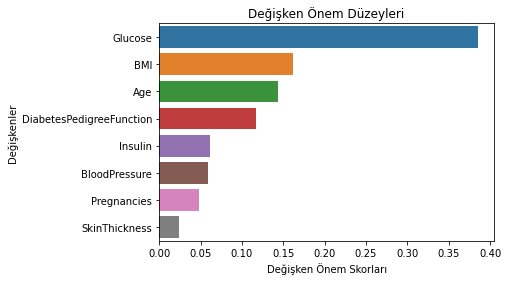

In [16]:
feature_imp = pd.Series(gbm_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.savefig("Değişken Önem Düzeyleri")
plt.show()